### Workflow -- Forward Modeling

1. [For a given mantle composition, use perplex to generate material properties for T-P field (convert P to Z)](perplex/Plot_PT.ipynb)
2. [Assume a value for heatflow, then use xenoliths to invert for a range of geotherms](geotherm/Invert_for_Geotherm.ipynb)
3. Make a velocity model
  * Crustal constraints pulled from Crust1.0
  * Mantle constraints from perplex calculation
4. Run Mineos to compute phase velocities and compare with observations

In [20]:
#Step 1 - Import mappings for P-T calculation
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pylab as plt
%matplotlib inline
plt.style.use('ggplot')

import pickle
fin = open('perplex/dunite_stx11/funs.pickle','rb')
[frho,fvp,fvs] = pickle.load(fin)
fin.close()

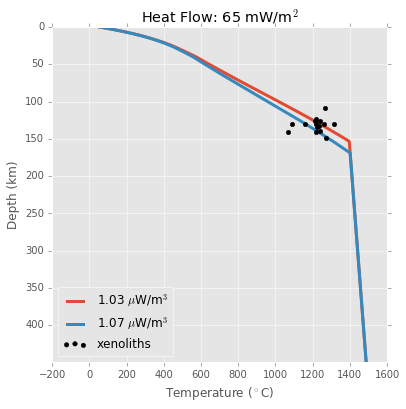

In [24]:
#Step 2 - Import range of geotherms
from geotherm import *
fig = plt.figure(1,(6,6))

gts={}

for tag in ['min','max']:

    fin = open('geotherm/geotherm_ColoradoPlateau_%s.pickle' % tag,'rb')
    gt = pickle.load(fin)
    fin.close()

    plt.plot(gt.temps,gt.depths,label='%.2f $\mu$W/m$^3$' % (gt.rhoH*10**6), lw=3)
    
    gts[tag] = gt
    
plt.scatter(gt.xeno_temps,gt.xeno_depths, label = 'xenoliths',zorder=1000, color='black')
plt.title('Heat Flow: %2d mW/m$^2$' % (gt.q0*1e3) )
plt.ylim(max(gt.depths),0)
_,_=plt.ylabel('Depth (km)'), plt.xlabel('Temperature ($^\circ$C)')
_ =plt.legend(loc=3)

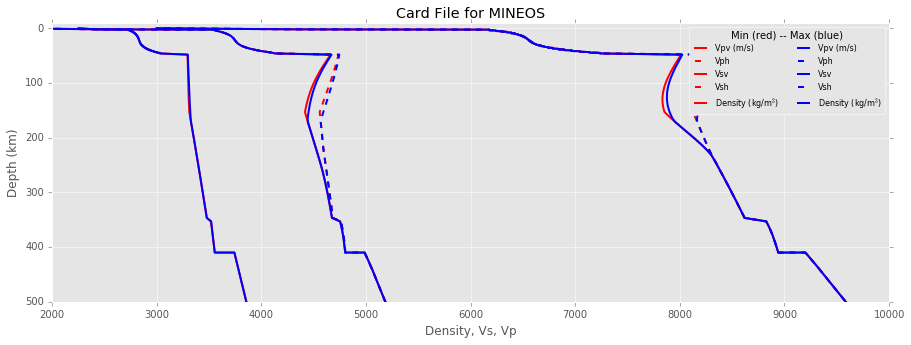

In [25]:
#Step 3 - Make velocity model and write to card file
from matplotlib import pylab as plt
%matplotlib inline
plt.style.use('ggplot')

#from crust1.crust1 import Crust1
#c = Crust1().load('crust1/crustal_model_ColoradoPlateau.pickle').print()
#zmoho = abs(c.model.Bottom[7])

from shen.shen import CrustalModel
c  = CrustalModel('coloplat')
zmoho = c.zmoho

def extract_profile(fun, gt):
    from scipy.interpolate import interp1d
    
    vs, zs = [],[]
    for ii, eachz in enumerate(gt.depths):
        
        val = fun(gt.temps[ii], eachz)
            
        vs.append(val[0])
        zs.append(eachz)
    
    return interp1d(zs,vs)
    
    
from minos.minos import CardFile
from attenuation.attenuation import AttenuationProfile

fqmu = AttenuationProfile('seismic_JF10_gs10mm_Temp_AD0p40_TP1350_ZG155').setup_interpolation_functions()

ls = ['red','blue']

for kk,tag in enumerate(gts):
    fvp_gt  = extract_profile(fvp, gts[tag])
    fvs_gt  = extract_profile(fvs, gts[tag])
    frho_gt = extract_profile(frho, gts[tag])

    cf = CardFile().read('minos/STW105.txt')
    cf0 = CardFile().read('minos/STW105.txt')
    cf0=cf0.set_mantle_region(fvp_gt, fvs_gt, frho_gt, zmoho=zmoho)
    cf0=cf0.set_mantle_attenuation(fqmu, zmoho=zmoho)
    
    #cf0=cf0.set_crustal_region(c.model)
    cf0=cf0.set_crustal_region_shen(c.model, zmoho)
    
    cf0.write(filename='minos/%s.txt' % tag)

    plt.figure(2,figsize=(15,5))
    _ = plt.plot(cf0.df.Vpv, 6371-cf0.df.Radius/1000, lw = 2, label = 'Vpv (m/s)', c=ls[kk])
    _ = plt.plot(cf0.df.Vph, 6371-cf0.df.Radius/1000, lw = 2, label = 'Vph', c=ls[kk], ls ='--')
    #_ = plt.plot(cf.df.Vpv, 6371-cf.df.Radius/1000, '--k', lw = 0.5)
    _ = plt.ylim(500,0)

    _ = plt.plot(cf0.df.Vsv, 6371-cf0.df.Radius/1000,label='Vsv', lw=2, c=ls[kk])
    _ = plt.plot(cf0.df.Vsh, 6371-cf0.df.Radius/1000,label='Vsh', lw=2, c=ls[kk], ls ='--')
    #_ = plt.plot(cf.df.Vsv, 6371-cf.df.Radius/1000, '--k', lw = 0.5)

    _ = plt.plot(cf0.df.Density, 6371-cf0.df.Radius/1000,label='Density (kg/m$^3$)', lw=2, c=ls[kk])
    #_ = plt.plot(cf.df.Density, 6371-cf.df.Radius/1000, '--k', lw = 0.5)

_ = plt.ylim(500,-10)
_ = plt.xlim(2000, 10000)
_ = plt.title("Card File for MINEOS")
_ = plt.ylabel('Depth (km)')
_ = plt.xlabel('Density, Vs, Vp')
_ = plt.legend(ncol=2,fontsize=8,title='Min (red) -- Max (blue)')

**Note**: At depths > 350 km, the Card File pulls direct values from STW105, resulting in artificial discontinuities around that depth.

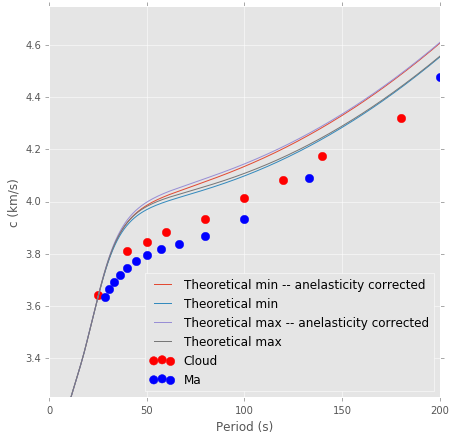

In [26]:
#Step 4 - Compute phase velocities and compare with observed

from minos.minos import Minos
from observations.observations import PhaseVelocities
pv1 = PhaseVelocities(36,-110,"Cloud")
pv2 = PhaseVelocities(36,-110,"Ma")

fig = plt.figure(1,(7,7))

for tag in gts:
    for ref_period in [-1.0, 1.0]:
        cf = CardFile().read('minos/%s.txt' % tag).write(filename='minos/%s.txt' % tag, ref_period=ref_period)
        minos = Minos(tag).run().read_output()

        
        if ref_period < 0:
            tag2 = '-- anelasticity corrected'
        else:
            tag2 = ''
        
        _ = plt.plot(minos.period, minos.c, label='Theoretical %s %s' % (tag, tag2))
 

colors = ['red','blue']
labels = ['Cloud','Ma']

for kk,pv in enumerate([pv1, pv2]):
    xs,ys = [],[]
    for key in pv.measurements:
        xs.append(key)
        ys.append(pv.measurements[key]/1000.)

    _ = plt.scatter(xs, ys, s=70, label=labels[kk], color=colors[kk])
    
plt.xlim(0,200)
plt.ylim(3.25,4.75)
plt.ylabel('c (km/s)')
plt.xlabel('Period (s)')

_ = plt.legend(loc=4)